https://pandas.pydata.org/docs/user_guide/10min.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from wt_import import Wt_Importer


Set file for analysis

In [2]:
wt_full_sample = 'C:\\Users\\ecountrywood\\dev\\pandas\\data\\PA_sample_data.csv'
wt_short_sample = 'C:\\Users\\ecountrywood\\dev\\pandas\\data\\PA_sample_data_short.csv'
wt_micro_sample = "C:\\Users\\ecountrywood\\dev\\pandas\\data\\PA_micro.csv"
vv_data_sample = "C:\\Users\\ecountrywood\\dev\\pandas\\data\\volt-var\\EUT_20_2.csv"
watt_var_sample = "C:\\Users\\ecountrywood\\dev\\pandas\\data\\watt-var\\eut_100.csv"

df = Wt_Importer(watt_var_sample).df
df.head()

,Store No.,Date,Time,Millisecond,U-1-Total,I-1-Total,P-1-Total,S-1-Total,Q-1-Total,PF-1-Total,...,CfI-1-Total,U-2-Total,I-2-Total,P-2-Total,S-2-Total,Q-2-Total,PF-2-Total,Phi-2-Total,FreqU-2-Total,FreqI-2-Total
1,1,2022/04/28,10:21:35,644,120.086,0.413,48.5,49.6,-10.6,0.97678,...,NaN,120.004,0.368,41.6,44.2,-14.9,0.94119,-19.747,60.002,NaN
2,2,2022/04/28,10:21:36,148,120.093,0.426,50.0,51.1,-10.9,0.97692,...,NaN,120.050,0.375,42.8,45.0,-14.0,0.95004,-18.188,60.001,NaN
3,3,2022/04/28,10:21:36,649,120.080,0.423,49.0,50.9,-13.7,0.96298,...,NaN,120.012,0.379,42.8,45.5,-15.6,0.93976,-19.988,60.001,NaN
4,4,2022/04/28,10:21:37,150,120.087,0.418,49.0,50.2,-11.0,0.97558,...,NaN,119.989,0.371,41.6,44.5,-15.9,0.93419,-20.902,60.001,NaN
5,5,2022/04/28,10:21:37,695,120.098,0.421,49.2,50.5,-11.5,0.97379,...,NaN,120.019,0.362,41.3,43.5,-13.5,0.95061,-18.083,60.002,NaN


Begin working with the dataframe:
- take a subset of the columns
- take phase 1 voltage and total reactive power

In [3]:
# df_cols_1_2 = df[['U-1-Total','Q-SigmaA-Total']]
# df_VQ = df_cols_1_2.rename(columns= {"U-1-Total":"V1","Q-SigmaA-Total":"Q_total"})
# df_VQ.head(3)
df['sumP'] = df['P-1-Total'] + df['P-2-Total']
df['sumQ'] = df['Q-1-Total'] + df['Q-2-Total']
df['sumQ'].head()

# print(df['Q-1-Total'].iloc[0])

1   -25.5
2   -24.9
3   -29.3
4   -26.9
5   -25.0
Name: sumQ, dtype: float64

Extract Voltage and Vars timeseries

In [4]:
vs = df['sumP'].to_numpy(dtype=float, copy=True)   # Voltage Timeseries
vq = df['sumQ'].to_numpy(dtype=float, copy=True)   # Var Timeseries

Downsample for easier stepfinding

In [5]:
n = 10# take every 10th sample
vs = vs[::n] 
vq = vq[::n]

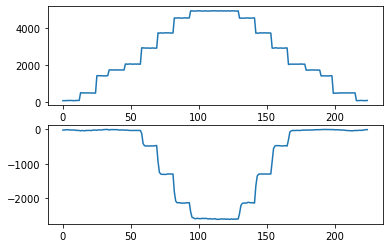

In [6]:

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.figsize=(16,2); ax2.figsize=(16,2)
ax1.plot(vs); ax2.plot(vq)

# Step finding
numpy.gradient() - keeping here for future cases where identifying edges of change `interval` is important

numpy.diff()

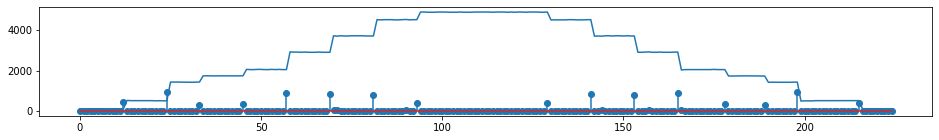

In [7]:
vdif = np.abs(np.diff(vs, append=vs[0] ))
plt.figure(figsize=(16,2))
plt.stem(vdif)
plt.plot(vs)
# plt.stem(vdif[0:20]) # first 20 samples of difference array

create binary array where steps are represented by boolean(1)

<StemContainer object of 3 artists>

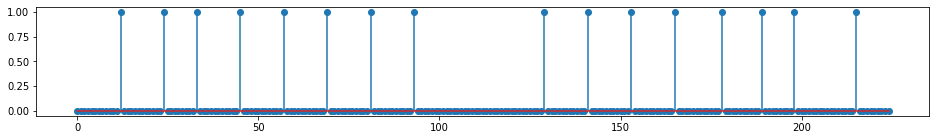

In [8]:
vbin = vdif > 100
plt.figure(figsize=(16,2))
plt.stem(vbin)

Get the index of each change point and plot change poits over original timeseries

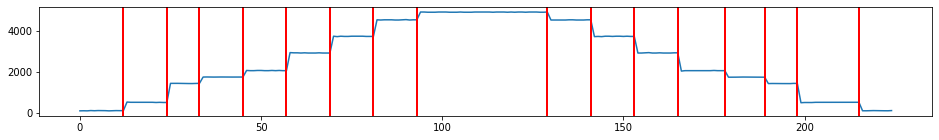

In [9]:
from Numpy_utils import plot_change_points 

change_points = np.where(vbin)[0]
plot_change_points(vs,change_points)

In [10]:
from Numpy_utils import get_change_points
change_points

array([ 12,  24,  33,  45,  57,  69,  81,  93, 129, 141, 153, 165, 178,
       189, 198, 215], dtype=int64)

Get average value of each step in timeseries:
- define a window (as percent of step length) 
- place the uppermost window edge at uppermost edge of each interval defined by change locations 
- take the mean of the timeseries values in the window

In [11]:
from Numpy_utils import get_step_values
cp = get_change_points(vs)
v_idxs, v_vals = get_step_values(vs,cp)
q_idxs, q_vals = get_step_values(vq,cp)

<StemContainer object of 3 artists>

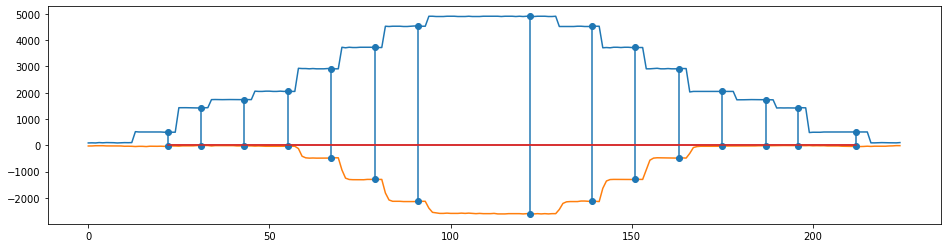

In [12]:
plt.figure(figsize=(16,4))
plt.plot(vs)
plt.stem(v_idxs,v_vals)
plt.plot(vq)
plt.stem(q_idxs,q_vals)

In [13]:
VQ = pd.DataFrame({'volt': v_vals,
                   'var': q_vals})
VQ

,volt,var
0,502,-31
1,1423,-10
2,1738,-23
3,2055,-37
4,2912,-483
5,3725,-1298
6,4530,-2135
7,4906,-2604
8,4522,-2127
9,3725,-1298
